# 프로젝트

In [1]:
import glob
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['[Hook]', "I've been down so long, it look like up to me", 'They look up to me']


## 데이터 정제

In [3]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
import re
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))
print(preprocess_sentence("Thissentence."))
print(preprocess_sentence("I eat lunch"))

<start> this is sample sentence . <end>
<start> thissentence . <end>
<start> i eat lunch <end>


In [4]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue # 길이가 0인 문장은 건너뜁니다
    if len(sentence) > 50: continue
    if sentence[-1] == ":": continue # 문장의 끝이 :인 문장은 건너뜁니다
        
    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

['<start> hook <end>',
 '<start> i ve been down so long , it look like up to me <end>',
 '<start> they look up to me <end>',
 '<start> i got fake people showin fake love to me <end>',
 '<start> straight up to my face , straight up to my face <end>',
 '<start> i ve been down so long , it look like up to me <end>',
 '<start> they look up to me <end>',
 '<start> i got fake people showin fake love to me <end>',
 '<start> somethin ain t right when we talkin <end>',
 '<start> somethin ain t right when we talkin <end>']

## 토큰화

In [6]:
import tensorflow as tf 

def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,  # 전체 단어의 개수 
        filters=' ',    # 별도로 전처리 로직을 추가할 수 있습니다. 이번에는 사용하지 않겠습니다.
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 어떤 토큰으로 대체할지
    )
    tokenizer.fit_on_texts(corpus)   # 우리가 구축한 corpus로부터 Tokenizer가 사전을 자동구축하게 됩니다.

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.

    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
    # maxlen의 디폴트값은 None입니다. 이 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰집니다.
    # maxlen=15를 설정해서 토큰의 개수가 15개를 최대로 설정, 15개 초과하는 데이터는 제외
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2  941    3 ...    0    0    0]
 [   2    4   94 ...   10   12    3]
 [   2   46  134 ...    0    0    0]
 ...
 [   2  198    3 ...    0    0    0]
 [   2  442    9 ...    0    0    0]
 [   2    9 1610 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f086990a390>


In [7]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])
print(len(src_input))
print(len(tgt_input))

[  2 941   3   0   0   0   0   0   0   0   0   0   0   0]
[941   3   0   0   0   0   0   0   0   0   0   0   0   0]
142443
142443


## 평가 데이터셋 분리

In [9]:
# train, test 분리

from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True)

print("Source Train:", enc_train.shape) # 소스 문장
print("Target Train:", dec_train.shape) # 타겟 문장

Source Train: (113954, 14)
Target Train: (113954, 14)


In [10]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset1 = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(BUFFER_SIZE)
dataset1 = dataset1.batch(BATCH_SIZE, drop_remainder=True)
print(dataset1)

dataset2 = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).shuffle(BUFFER_SIZE)
dataset2 = dataset2.batch(BATCH_SIZE, drop_remainder=True)
print(dataset2)

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>
<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>


In [11]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [12]:
for src_sample, tgt_sample in dataset1.take(1): break
print(model(src_sample))

tf.Tensor(
[[[-6.21630315e-05  5.10329774e-05 -2.28092013e-05 ...  1.07920874e-04
    1.30119706e-05 -1.97675195e-06]
  [-2.76733736e-05  3.83767110e-06 -6.26690598e-05 ...  1.37086274e-04
    4.02425685e-05  7.19083546e-05]
  [-2.38473993e-04  3.72791510e-06  3.47908463e-06 ...  2.20556947e-04
    1.78690985e-04  8.85536356e-05]
  ...
  [-6.23432163e-04 -2.02017813e-03  1.20721222e-03 ...  3.18764505e-04
    1.48974895e-03 -8.22309579e-04]
  [-8.48433876e-04 -2.15080590e-03  1.44522812e-03 ...  1.01578080e-04
    1.70652894e-03 -9.18670266e-04]
  [-1.05173502e-03 -2.24655494e-03  1.69291743e-03 ... -1.01305712e-04
    1.91392959e-03 -1.02263270e-03]]

 [[-6.21630315e-05  5.10329774e-05 -2.28092013e-05 ...  1.07920874e-04
    1.30119706e-05 -1.97675195e-06]
  [-1.24104583e-04 -2.27344281e-04  1.26052691e-04 ...  1.91734813e-04
   -8.30904974e-05 -4.83854990e-07]
  [-3.60056205e-04 -4.15128830e-04  3.26851179e-04 ...  5.45707298e-04
    1.56098267e-05 -3.03688576e-04]
  ...
  [-1.182720

In [13]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [14]:
# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

val_loss를 낮추기 위한 노력

- 조기종료(early stopping)은 Neural Network가 과적합을 회피하도록 만드는 정칙화(regularization) 기법 중 하나이다
- 훈련 데이터와는 별도로 검증 데이터(validation data)를 준비하고, 
- 매 epoch 마다 검증 데이터에 대한 오류(validation loss)를 측정하여 모델의 훈련 종료를 제어한다. 
- 구체적으로, 과적합이 발생하기 전 까지 training loss와 validaion loss 둘다 감소하지만, 
- 과적합이 일어나면 training loss는 감소하는 반면에 validation loss는 증가한다. 
- 그래서 early stopping은 validation loss가 증가하는 시점(overfitting이 시작되려는 시점)에서 훈련을 종료한다.
- 출처: https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=cjh226&logNo=221468928164 

In [16]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5)]

In [17]:
model_history = model.fit(dataset1,
                          batch_size=32,
                          epochs=10,
                          validation_data = dataset2,
                          callbacks=callbacks)

Epoch 1/10
445/445 [==============================] - 163s 359ms/step - loss: 3.9027 - accuracy: 0.4744 - val_loss: 2.9786 - val_accuracy: 0.5393
Epoch 2/10
445/445 [==============================] - 161s 360ms/step - loss: 2.9082 - accuracy: 0.5416 - val_loss: 2.8019 - val_accuracy: 0.5531
Epoch 3/10
445/445 [==============================] - 161s 361ms/step - loss: 2.7317 - accuracy: 0.5548 - val_loss: 2.6959 - val_accuracy: 0.5611
Epoch 4/10
445/445 [==============================] - 159s 357ms/step - loss: 2.6022 - accuracy: 0.5633 - val_loss: 2.6218 - val_accuracy: 0.5672
Epoch 5/10
445/445 [==============================] - 158s 354ms/step - loss: 2.5001 - accuracy: 0.5701 - val_loss: 2.5618 - val_accuracy: 0.5728
Epoch 6/10
445/445 [==============================] - 159s 356ms/step - loss: 2.4106 - accuracy: 0.5770 - val_loss: 2.5165 - val_accuracy: 0.5779
Epoch 7/10
445/445 [==============================] - 158s 354ms/step - loss: 2.3232 - accuracy: 0.5847 - val_loss: 2.4730 -

In [18]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <end>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

In [19]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , baby <end> '

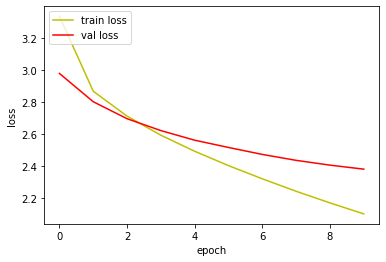

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()


loss_ax.plot(model_history.history['loss'], 'y', label='train loss')
loss_ax.plot(model_history.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

## 결론

- val_loss가 계속 2.3 밑으로는 떨어지지 않아 early stopping 등 조치를 취했지만 2.2 이하로는 떨어지지 않는다.
- 다른 방법으로도 계속 시도해보고 있는데 좀 더 방법을 찾아보고 val_loss에 대한 업데이트가 필요하다